# 2.1.2 Stacked LSTMs on Fractals

PredNet representations match the ones of human fMRI. How about LSTMS?

## Jupyter Extensions

Load [watermark](https://github.com/rasbt/watermark) to see the state of the machine and environment that's running the notebook. To make sense of the options, take a look at the [usage](https://github.com/rasbt/watermark#usage) section of the readme.

In [1]:
# Load `watermark` extension
%load_ext watermark
# Display the status of the machine and other non-code related info
%watermark -n -m -g -b -t -h

Mon Sep 07 2020 19:41:29 

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-112-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 16
interpreter: 64bit
host name  : serrep5
Git hash   : 59e0a6edddffbf3fb2a36b25ae4d5e677184b7bf
Git branch : master


Load [autoreload](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html) which will always reload modules marked with `%aimport`.

This behavior can be inverted by running `autoreload 2` which will set everything to be auto-reloaded *except* for modules marked with `%aimport`.

In [2]:
# Load `autoreload` extension
%load_ext autoreload
# Set autoreload behavior
%autoreload 1

Load `matplotlib` in one of the more `jupyter`-friendly [rich-output modes](https://ipython.readthedocs.io/en/stable/interactive/plotting.html). Some options (that may or may not have worked) are `inline`, `notebook`, and `gtk`.

In [3]:
# Set the matplotlib mode
%matplotlib inline

## Imports

In [4]:
import gc
import logging
from argparse import Namespace
from pathlib import Path

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pytorch_lightning as pl
from PIL import Image, ImageOps
from torch.utils.data import IterableDataset, DataLoader

%aimport prevseg.constants
import prevseg.constants as const
%aimport prevseg.index
import prevseg.index as index
%aimport prevseg.dataloaders.schapiro
import prevseg.dataloaders.schapiro as sch
%aimport prevseg.schapiro
from prevseg.schapiro import walk, graph
%aimport prevseg.models.prednet
import prevseg.models.prednet as pn
%aimport prevseg.torch.lstm
import prevseg.torch.lstm as lstm
%aimport prevseg.torch.activations
import prevseg.torch.activations as act


# Keep track of versions of everything
%watermark -v -iv

networkx          2.4
prevseg           0+untagged.86.g59e0a6e.dirty
torch             1.4.0
numpy             1.19.1
logging           0.5.1.2
pytorch_lightning 0.8.5
PIL.Image         7.2.0
CPython 3.8.5
IPython 7.16.1


## Defining the Stacked LSTM

In [68]:
class LSTMCell(pn.PredCellTracked):
    name = 'lstmcell'
    
    def __init__(self, parent, layer_num, hparams, a_channels, r_channels, *args, **kwargs):
        self.build_dense = lambda *args, **kwargs : None
        self.build_update = lambda *args, **kwargs : None
        super().__init__(parent, layer_num, hparams, a_channels, r_channels, *args, **kwargs)
        
    def build_recurrent(self):
        recurrent = self.RecurrentClass(
            self.a_channels[self.layer_num],
            #+ self.r_channels[self.layer_num+1],
            self.r_channels[self.layer_num])
        recurrent.reset_parameters()
        return recurrent
        
    def reset(self, batch_size=None):
        batch_size = batch_size or self.hparams.batch_size
        self.R = torch.zeros(1,                  # Single time step
                             batch_size,
                             self.r_channels[self.layer_num],
                             device=self.parent.dev)
        self.H = (torch.zeros(1,                  # Single time step
                              batch_size,
                              self.r_channels[self.layer_num],
                              device=self.parent.dev),
                  torch.zeros(1,                  # Single time step
                              batch_size,
                              self.r_channels[self.layer_num],
                              device=self.parent.dev))
        self.hidden_full_list = []
        self.hidden_diff_list = []
        self.representation_full_list = []
        self.representation_diff_list = []        
        
    def update_parent(self, module_names=('recurrent',)):
        return super().update_parent(module_names=module_names)

class LSTMStacked(pn.PredNetTrackedSchapiro):
    name = 'lstmstacked'
    def __init__(self, hparams, CellClass=LSTMCell, a_channels=None,
                 r_channels=None, *args, **kwargs):
        if not isinstance(hparams, Namespace):
            hparams = Namespace(**hparams)
        # Assertions for how it should be used
        assert hparams.layer_loss_mode is None
        
        if a_channels is None:
            a_channels = [hparams.input_size] * hparams.n_layers
        if r_channels is None:
            r_channels = list(a_channels) + [0,]
        # Run the init and cleanup
        super().__init__(hparams=hparams, CellClass=CellClass, r_channels=r_channels,
                         a_channels=a_channels, *args, **kwargs)
        # Add the last dense layer
        self.dense = nn.Sequential(
            nn.Linear(self.r_channels[hparams.n_layers - 1],
                      self.a_channels[0]),
            nn.ReLU())
        self.dense.add_module('satlu', act.SatLU())
        
        if torch.__version__ == '1.4.0' and torch.cuda.is_available():
            self.dense = self.dense.cuda()
            
        self.track = ['representation_diff', 'hidden_diff']

    def forward(self, input, output_mode=None, track=None, run_num=None,
                tb_labels=None):
        self.run_num = run_num or self.run_num
        self.tb_labels = tb_labels or self.tb_labels
        self.output_mode = output_mode or self.output_mode
        _, time_steps, *_ = self.check_input_shape(input)
        
        total_output = []

        for self.t in range(time_steps):
            self.frame = input[:,self.t,:].unsqueeze(0).to(self.dev, torch.float)
            A = self.frame
            for cell in self.cells:
                # First time step
                if self.t == 0:
                    hx = (cell.R, cell.R)
                else:
                    hx = cell.H
                    
                cell.R, cell.H = cell.recurrent(A, hx)
                # Optional tracking
                cell.track_hidden(self.output_mode, hx)
                cell.track_representation(self.output_mode, A)
                A = cell.R
                
            A_hat = self.dense(A)
            
            if self.output_mode == 'error':
                total_output.append(torch.abs(A_hat - self.frame))
            elif self.output_mode == 'prediction':
                total_output.append(A_hat)
        
        if self.output_mode == 'eval':
            return self.eval_outputs()
        else:
            return torch.stack(total_output, 2)

## Training the Model

In [33]:
hparams = const.DEFAULT_HPARAMS

ModelClass = LSTMStacked
hparams.layer_loss_mode = None
hparams.n_layers = 2
hparams.batch_size = 256 + 128 + 64
hparams.max_steps = 128
hparams.n_paths = 16
hparams.n_pentagons = 3
hparams.time_steps = hparams.max_steps
hparams.exp_name = 'schapiro_test'
hparams.name = f'{ModelClass.name}_{hparams.exp_name}'
hparams.debug = False
hparams.n_workers = 1
hparams.lr = 0.001
hparams.n_epochs = 25

train_model = False

In [6]:
if train_model:
    model, trainer = None, None
    train_dataloader, val_dataloader = None, None
    errors, optimizer = None, None
    ckpt = None
    train_errors, val_errors = None, None
    res = None
    gc.collect()
    torch.cuda.empty_cache()

    log_dir = Path(hparams.dir_logs) / f'{hparams.name}'
    if not log_dir.exists():
        log_dir.mkdir(parents=True)
    logger = pl.loggers.TensorBoardLogger(str(log_dir.parent), name=hparams.name)

    ckpt_dir = Path(hparams.dir_checkpoints) / f'{hparams.name}_v{logger.version}'
    if not ckpt_dir.exists():
        ckpt_dir.mkdir(parents=True)

    ckpt = pl.callbacks.ModelCheckpoint(
        filepath=str(ckpt_dir / (hparams.exp_name+'_{global_step:05d}_{epoch:03d}_{val_loss:.3f}')),
        verbose=True,
        save_top_k=1,
    )

    trainer = pl.Trainer(checkpoint_callback=ckpt,
                         max_epochs=hparams.n_epochs,
                         logger=logger,
                         gpus=1,
                         )

    model = ModelClass(hparams)
    model.ds = None
    model

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


LSTMStacked(
  (lstmcell_0_recurrent): LSTM(
    (i2h): Linear(in_features=2048, out_features=8192, bias=True)
    (h2h): Linear(in_features=2048, out_features=8192, bias=True)
  )
  (lstmcell_1_recurrent): LSTM(
    (i2h): Linear(in_features=2048, out_features=8192, bias=True)
    (h2h): Linear(in_features=2048, out_features=8192, bias=True)
  )
  (dense): Sequential(
    (0): Linear(in_features=2048, out_features=2048, bias=True)
    (1): ReLU()
    (satlu): SatLU (min_val=0, max_val=255)
  )
)

In [48]:
if train_model:
    trainer.fit(model)

In [69]:
if not train_model:
    # Get all the experiments with the name hparams.name*
    experiments = index.DIR_CHECKPOINTS.glob(f'{hparams.name}*')
    # Get the newest exp by v number
    experiment_newest = sorted(experiments, 
                               key=lambda path: int(path.stem.split('_')[-1][1:]))[-1]
    # Get the model with the best (lowest) val_loss
    experiment_newest_best_val = sorted(experiment_newest.iterdir(),
                                        key=lambda path: float(path.stem.split('val_loss=')[-1]))[0]
    experiment_newest_best_val
    
    model, trainer = None, None
    train_dataloader, val_dataloader = None, None
    errors, optimizer = None, None
    ckpt = None
    train_errors, val_errors = None, None
    res = None
    gc.collect()
    torch.cuda.empty_cache()

    model = LSTMStacked.load_from_checkpoint(str(experiment_newest_best_val))
    model.prepare_data()
    model.cuda()
    hparams = model.hparams

    log_dir = Path(hparams.dir_logs) / f'{hparams.name}'
    if not log_dir.exists():
        log_dir.mkdir(parents=True)
    logger = pl.loggers.TensorBoardLogger(str(log_dir.parent), 
                                          name=hparams.name,
                                          version=0)
    model.logger = logger

Created mapping as follows:
{0: '59', 1: '41', 2: '24', 3: '97', 4: '53', 5: '8', 6: '34', 7: '96', 8: '78', 9: '79', 10: '92', 11: '69', 12: '64', 13: '27', 14: '23'}
Created mapping as follows:
{0: '59', 1: '41', 2: '24', 3: '97', 4: '53', 5: '8', 6: '34', 7: '96', 8: '78', 9: '79', 10: '92', 11: '69', 12: '64', 13: '27', 14: '23'}


In [54]:
iter_ds = sch.ShapiroResnetEmbeddingDataset(
    batch_size=1, 
    max_steps=hparams.max_steps, 
    n_paths=1,
    mapping=model.ds.mapping,
    mode='euclidean')
loader = DataLoader(iter_ds, batch_size=None)

for data, nodes in loader:
    pass

Created mapping as follows:
{0: '59', 1: '41', 2: '24', 3: '97', 4: '53', 5: '8', 6: '34', 7: '96', 8: '78', 9: '79', 10: '92', 11: '69', 12: '64', 13: '27', 14: '23'}


In [56]:
data_all = torch.cat((data, torch.flip(data, (0,1))[:,1:,:]), 1)
data_all.shape

torch.Size([1, 59, 2048])

In [70]:
outs = model.forward(data_all, output_mode='eval', run_num='fwd_rev', 
                     tb_labels=['nodes'])

In [71]:
nodes = np.array(nodes).reshape(30)
nodes

array([11, 13, 14, 12, 13, 10, 12, 11, 14,  0,  3,  4,  2,  3,  1,  2,  0,
        1,  4,  5,  8,  9,  7,  8,  6,  7,  5,  6,  9, 10])

In [72]:
nodes_all = np.concatenate((nodes, np.flip(nodes)[1:]))
nodes_all.shape

(59,)

In [73]:
for i, val in enumerate(nodes_all):
    print(i, val)

0 11
1 13
2 14
3 12
4 13
5 10
6 12
7 11
8 14
9 0
10 3
11 4
12 2
13 3
14 1
15 2
16 0
17 1
18 4
19 5
20 8
21 9
22 7
23 8
24 6
25 7
26 5
27 6
28 9
29 10
30 9
31 6
32 5
33 7
34 6
35 8
36 7
37 9
38 8
39 5
40 4
41 1
42 0
43 2
44 1
45 3
46 2
47 4
48 3
49 0
50 14
51 11
52 12
53 10
54 13
55 12
56 14
57 13
58 11


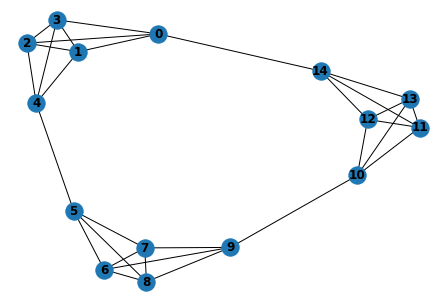

In [74]:
G = graph.schapiro_graph(n_pentagons=3)
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()

In [75]:
borders = [9, 19, 29, 30, 40, 50]

### Hidden State Differences

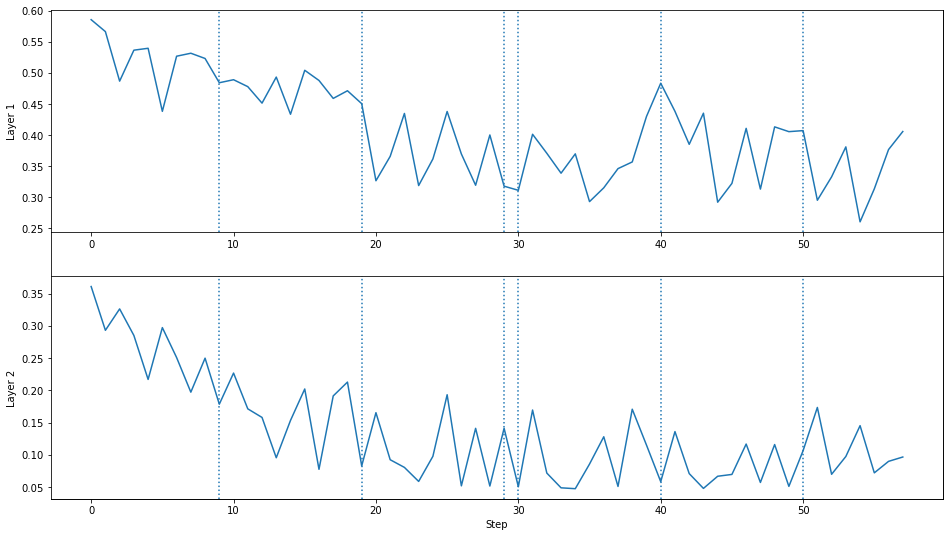

In [76]:
fig = plt.figure()
ax_large = fig.add_subplot(111)

for i, out in enumerate(outs['hidden_diff']):
    ax = fig.add_subplot(11 + i + len(outs['hidden_diff'])*100)
    ax.plot(np.array(out.cpu()).reshape(59)[1:])
    ax.set_ylabel(f'Layer {i+1}')
    [ax.axes.axvline(b, ls=':') for b in borders]
    if i == len(outs['hidden_diff'])-1:
        ax.set_xlabel('Step')
        
ax_large.axes.xaxis.set_ticks([])
ax_large.axes.yaxis.set_ticks([])
gcf = plt.gcf()
gcf.set_size_inches(16,9)

### Representation Differences

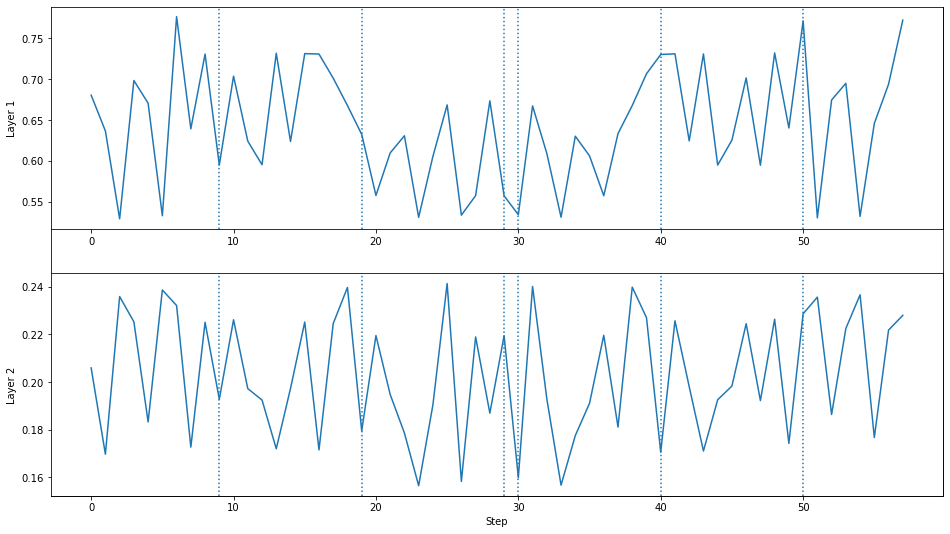

In [77]:
fig = plt.figure()
ax_large = fig.add_subplot(111)

for i, out in enumerate(outs['representation_diff']):
    ax = fig.add_subplot(11 + i + len(outs['representation_diff'])*100)
    ax.plot(np.array(out.cpu()).reshape(59)[1:])
    ax.set_ylabel(f'Layer {i+1}')
    [ax.axes.axvline(b, ls=':') for b in borders]
    if i == len(outs['representation_diff'])-1:
        ax.set_xlabel('Step')
        
ax_large.axes.xaxis.set_ticks([])
ax_large.axes.yaxis.set_ticks([])
gcf = plt.gcf()
gcf.set_size_inches(16,9)

### Alternating Within vs Between Communities

In [78]:
test_nodes = [6,8,9,
              10,9,10,
              13,12,14,
              0,14,0,
              1,2,4,
              5,4,5]
test_data = np.array([iter_ds.array_data[n] 
                      for n in test_nodes]).reshape((1,len(test_nodes),2048))

In [79]:
border_outs = model.forward(torch.Tensor(test_data), 
                            output_mode='eval', 
                            run_num='border_walk_3', 
                            tb_labels=['nodes'])

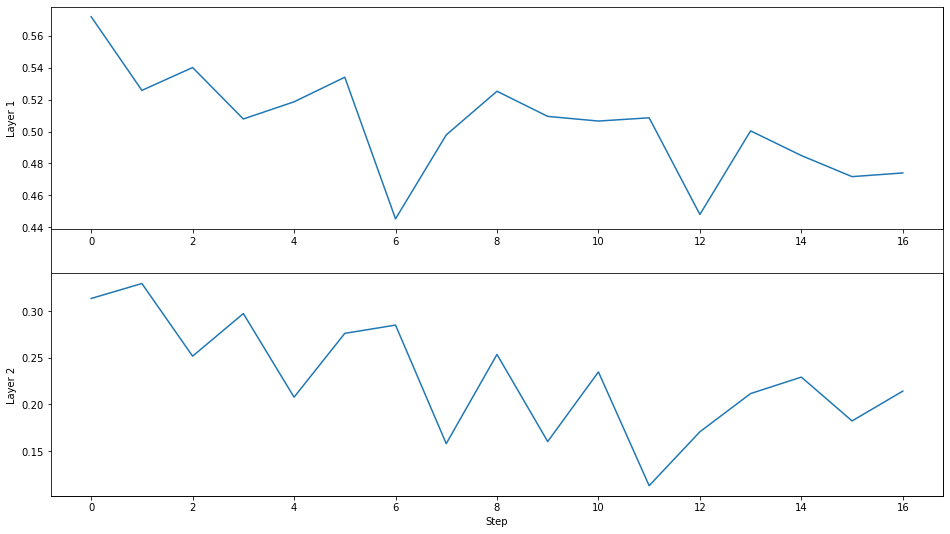

In [80]:
fig = plt.figure()
ax_large = fig.add_subplot(111)

for i, out in enumerate(border_outs['hidden_diff']):
    ax = fig.add_subplot(11 + i + len(border_outs['hidden_diff'])*100)
    ax.plot(np.array(out.cpu()).reshape(len(test_nodes))[1:])
    ax.set_ylabel(f'Layer {i+1}')
    if i == len(border_outs['hidden_diff'])-1:
        ax.set_xlabel('Step')
        
ax_large.axes.xaxis.set_ticks([])
ax_large.axes.yaxis.set_ticks([])
gcf = plt.gcf()
gcf.set_size_inches(16,9)